In [1]:
# 2023 Gabriel J. Diaz @ RIT

import os
import sys
import numpy as np
import av
import logging
import pickle
from tqdm import tqdm


import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pathlib import Path, PurePath

import sys
sys.path.append('../..')
from flow_source import *

logger = logging.getLogger(__name__)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [2]:
a_file_path = Path(os.path.join('..','..','pupil_labs_data','GD-Short-Driving-Video'))
#a_file_path = Path(os.path.join('..','..','pupil_labs_data','cb13'))
a_file_path
source = pupil_labs_source(a_file_path)

In [3]:
def set_video_target(self, file_path = False):
    
    if not file_path:
        
        Tk().withdraw()  # we don't want a full GUI, so keep the root window from appearing
        file_path = askopenfilename(title="Select the video on which to overlay gaze",
                                               initialdir=self.recording_folder)
        
    
    self.video_target_path = file_path
    return True


import types
source.set_video_target = types.MethodType( set_video_target, source )


In [4]:
p = Path('D:/Github/retinal_flow_toolkit/pupil_labs_data/GD-Short-Driving-Video/S001/PupilData/007/exports/003/world_nvidia2_hsv_overlay.mp4').as_posix()
# p = Path('D:\Github\retinal_flow_toolkit\pupil_labs_data\GD-Short-Driving-Video\S001\PupilData\007\world.mp4').as_posix()
# p = Path('D:\Github\retinal_flow_toolkit\flow_out\yoyo_640_480_60hz_2\yoyo_640_480_60hz_2_nvidia2_hsv_overlay.mp4').as_posix()

source.set_video_target(p)

True

In [5]:
img_out_path = 'image_out/'

if os.path.exists(img_out_path) is False:
    os.mkdir(img_out_path)

In [6]:
video = cv2.VideoCapture(source.video_target_path)

In [7]:
count = 0
success = 1
while success and count < 100:
    
    success, image = video.read()
    
    if success:
        cv2.imwrite(f"{img_out_path}/{count}.jpg", image)
        
    count = count + 1

print(count)

100


In [8]:
success

True

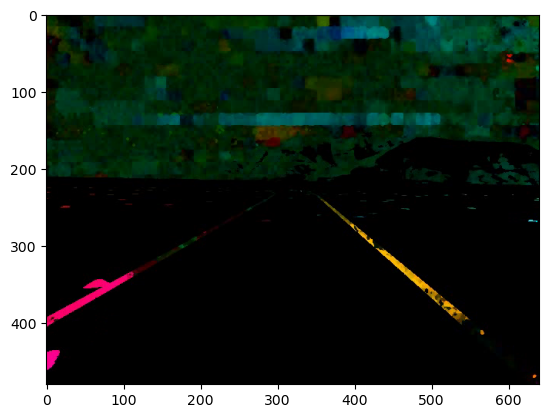

In [9]:
# success, image = video.read()
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [17]:
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
h = hsv_image[...,0]
s = hsv_image[...,1]
v = hsv_image[...,2]

In [18]:
hue_flat = h.flatten()
# hue_flat[np.where(s.flatten()==0)[0]] = 0 
# hue_flat = hue_flat # map to 360
hue_flat = hue_flat[hue_flat>0] 
#scaled_hue = hue_flat * v.flatten()[h.flatten()>0]

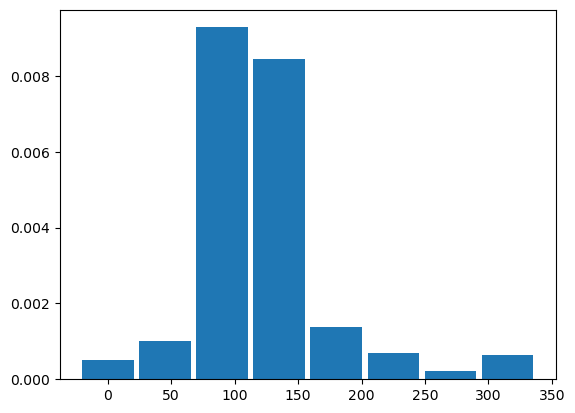

In [19]:
hist_params = (4*2, 0, 360)
counts, bins = np.histogram(hue_flat*2.0, hist_params[0], (hist_params[1], hist_params[2]),density=True);
plt.bar(bins[:-1], height=counts, width=.9*(bins[1]-bins[0]));

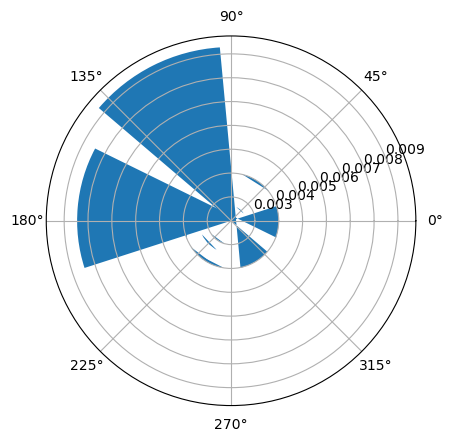

In [20]:
ax = plt.subplot(111, polar=True)
bars = ax.bar(bins[:-1], counts, bottom=0.0)
ax.set_ylim(.002)
plt.show()

In [14]:
hue_flat

array([ 43,  37,  46, ..., 148, 170, 170], dtype=uint8)

In [15]:
from collections import deque

buffer_len = 10
counts = deque(np.zeros(16), buffer_len)
counts.appendleft(np.ones(16))
counts



deque([array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
       0.0,
       0.0,
       0.0,
       0.0,
       0.0,
       0.0,
       0.0,
       0.0,
       0.0])

In [16]:
np.ones(16)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])